In [1]:
import pandas as pd, numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from ResearchML import *

workPath = "/home/xetra/AlphaGoldmine/Data/"
future = "CL"
y = 2018

contFuture = os.path.join(workPath, future.lower(), f"{future}Cont")
contFutureMLOLD = os.path.join(workPath, future.lower(), f"{future}ContML")

vbPath = os.path.join(workPath, future.lower(), f"{future}ContVB")
contFutureLevelBucketsVB = os.path.join(workPath,future.lower(), f"{future}ContLevelBuckets")
vpDir = os.path.join(workPath,future.lower(),"VP")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
df = pd.read_feather(contFuture).set_index("date")
vb = pd.read_feather(vbPath).set_index("date")  

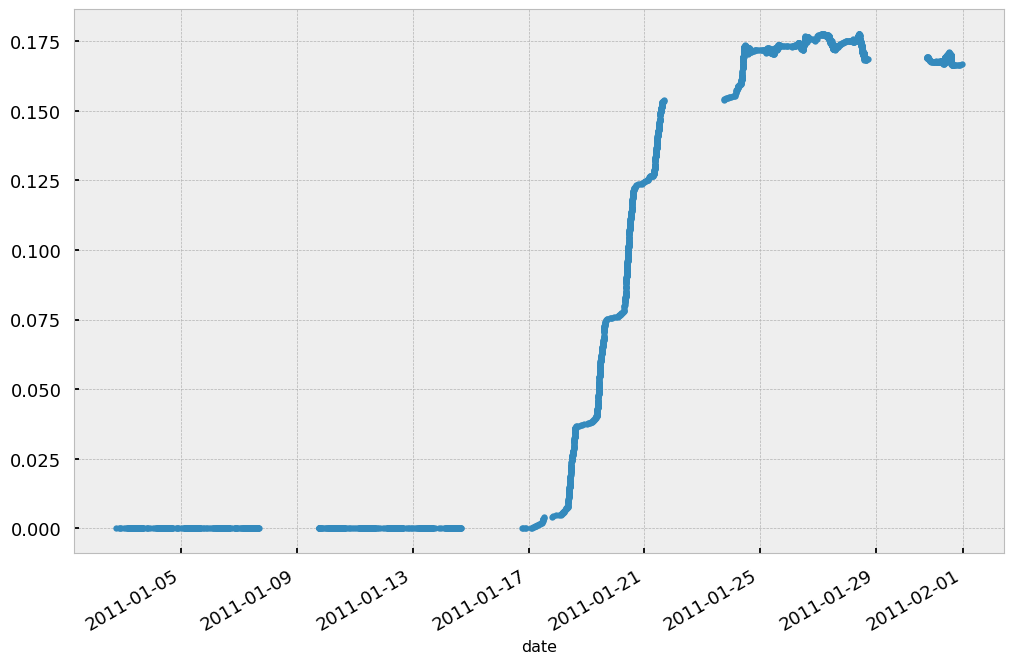

In [3]:
vb.loc[(vb.index.year==2011)&(vb.index.month==1),"VPIN"].plot(style=".")
vb = vb.loc[vb.index.date>=parse("2011-01-25").date()] #cut out bad data due to missing volume

### Add stuff from transformation.ipynb

In [4]:
trgt = getDailyVol(df["c"],span0=100)
t1 = getT1(df["c"],vb.index,span=pd.Timedelta(hours=8))
f=15
vpinCUSUM = getTEvents(vb["VPIN"],round(vb['VPIN'].replace(0,np.nan).dropna().std()/f,4))
events = getEvents(close=df["c"],tEvents=vpinCUSUM,ptSl=[1],trgt=trgt,minRet=trgt.quantile(.25),numThreads=10,t1=t1)
out = getBins(events=events,close=df["c"])
out = out[out.bin != 0]
events = events.loc[out.index]

2021-03-16 10:04:46.495936 100.0% applyPtSlOnT1 done after 0.04 minutes. Remaining 0.0 minutes.


#### Overlaping Labels

In [5]:
numCoEvents=mpPandasObj(mpNumCoEvents,("molecule",events.index),numThreads=12,closeIdx=df.index,t1=events["t1"])
numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep="last")]
numCoEvents=numCoEvents.reindex(df.index).fillna(0)
out["tW"]=mpPandasObj(mpSampleTW,("molecule",events.index),numThreads=12,t1=events["t1"],numCoEvents=numCoEvents)

2021-03-16 10:05:04.050063 100.0% mpNumCoEvents done after 0.03 minutes. Remaining 0.0 minutes.
2021-03-16 10:05:09.359723 100.0% mpSampleTW done after 0.05 minutes. Remaining 0.0 minutes.


In [6]:
out["w"]=mpPandasObj(mpSampleW,("molecule",events.index),numThreads=14,t1=events["t1"],numCoEvents=numCoEvents,close=df["c"])

2021-03-16 10:05:14.197778 100.0% mpSampleW done after 0.08 minutes. Remaining 0.0 minutes.


In [7]:
out["t1"] = t1

-------------

# Modeling

## creating some features

## Ensamble Methods

### The Three Sources of Errors

ML models generally suffer from three errors
- **Bias**: This error is caused by unrealistic assumptions. When bias
is high, the ML algorithm has failed to recognize important
relations between features and outcomes. In this situation, the
algorithm is said to be *“underfit.”*

- **Variance**: This error is caused by sensitivity to small changes in
the training set. When variance is high, the algorithm has *overfit*
the training set, and that is why even minimal changes in the
training set can produce wildly different predictions. Rather than
modelling the general patterns in the training set, the algorithm
has mistaken noise with signal.

- **Noise**: This error is caused by the variance of the observed
values, like unpredictable changes or measurement errors. This is
the irreducible error, which cannot be explained by any model.

### Bootstrap Aggregation
Helps in reducing the variance in forecasts.

#### How it works
1. Generate $N$ training datasets by random sampling **with remplacement**
2. Fit $N$ estimators, one on each set. Estimators are fit independently, hence the models can be fin in parallel.
3. The ensamble forecast is the simple average of the cariables, the probability that an observation belongs to a class is given by the proportion of estimators that classify that observation as a memner of that class (**majority voting**)

Base estimator makes a forecast with a prdecition prbability and bagging classifier may derive a mean of the probabilities.

### Improved Accuracy
The implication is that for a sufficiently large $N$, say $N > p(p-l/k)^{-2}$ then $p > 1/k => P[X>N/k] > p$, hence the bagging classifier's accuracy exceeds the average accuracy of the individual classifiers.

However,
unlike boosting, bagging cannot improve the accuracy of poor classifiers: If the individual learners are poor classifiers $(p<<1/k)$, majority voting will still perform poorly.

In [8]:
dfMl = pd.read_feather(contFutureLevelBucketsVB).set_index("date")
dfOld = pd.read_feather(contFutureMLOLD).set_index("date")

In [9]:
cols = ["relCVD","OFI",'ttFomc','ttInv','teaCVbCUSUM','teaVToPCUSUM','ttUsOpen','ttEuOpen','ttUsClose','teaFomc', 'teaInv']
buckets = [c for c in dfMl.columns if c.endswith("B")]

In [10]:
vb.loc[vb.index,buckets] = dfMl.loc[dfMl.index.intersection(vb.index),buckets]
vb.loc[vb.index,cols] = dfMl.loc[dfMl.index.intersection(vb.index),cols]

In [11]:
vb["teaInv"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.inv==1].index,y=-.7)
vb["teaFomc"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.fomc==1].index,y=-.7)
vb["teaCVbCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.cVbCUSUM==1].index,y=-.7)
vb["teaVToPCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.vToPCUSUM==1].index,y=-.7)

In [12]:
vpin = vb.loc[events.index]

In [13]:
vpin["teaInv"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.inv==1].index,y=-.7).loc[events.index]
vpin["teaFomc"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.fomc==1].index,y=-.7).loc[events.index]
vpin["teaCVbCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.cVbCUSUM==1].index,y=-.7).loc[events.index]
vpin["teaVToPCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.vToPCUSUM==1].index,y=-.7).loc[events.index]

In [14]:
def showNanRatio(df):
    displayAll((df.isnull().sum().sort_index()/len(df)).sort_values(ascending=False))

In [15]:
vpin = vpin.drop(["teaVToPCUSUM"],1)

In [16]:
vb = vb.drop(["teaVToPCUSUM"],1)

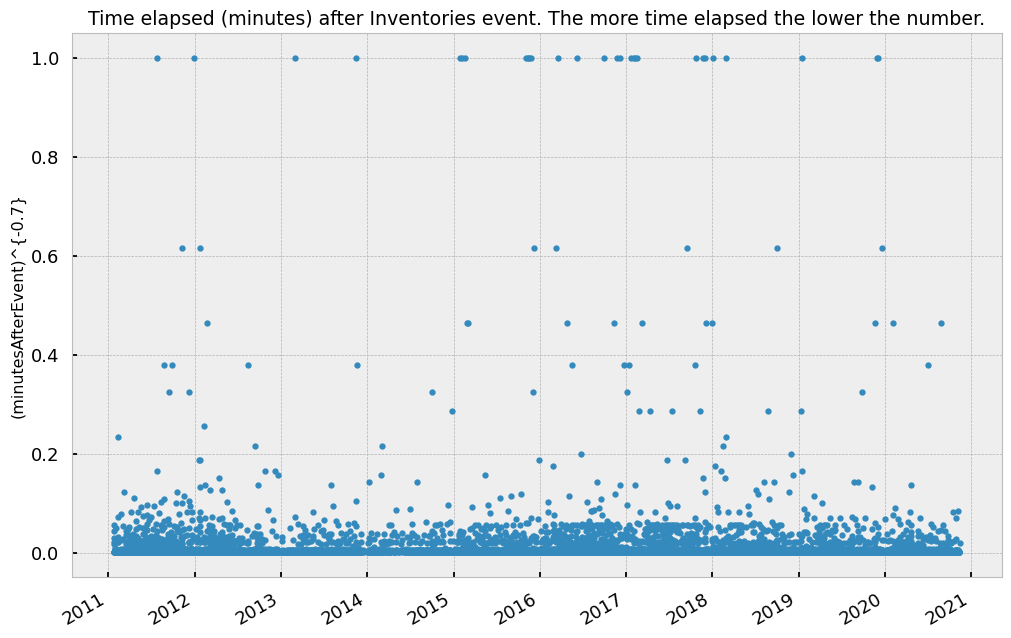

In [17]:
vpin.teaInv.plot(style=".",title="Time elapsed (minutes) after Inventories event. The more time elapsed the lower the number.", ylabel="(minutesAfterEvent)^{-0.7}")

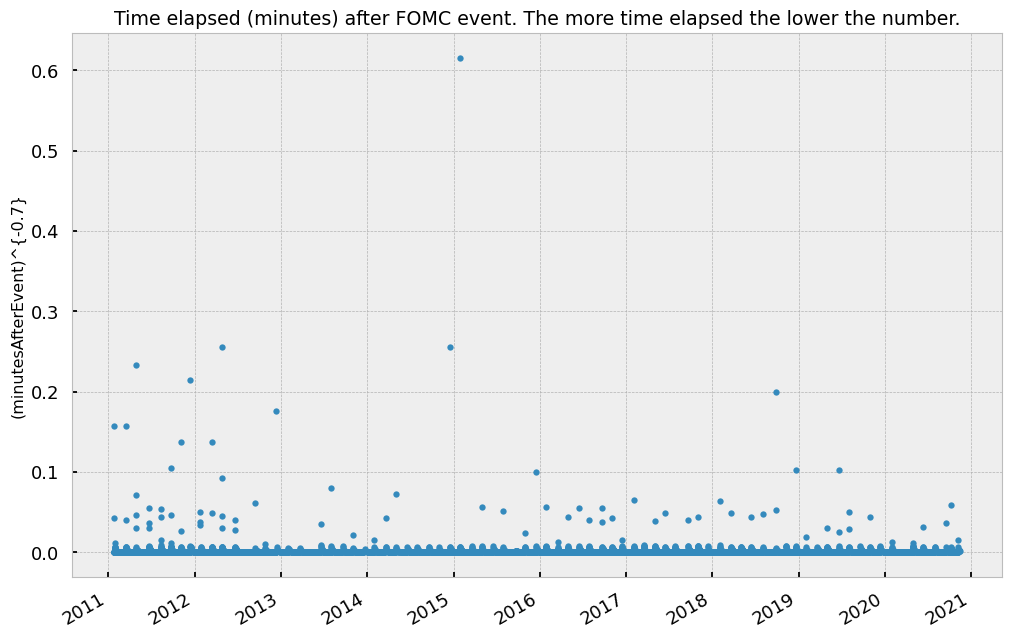

In [18]:
vpin.teaFomc.plot(style=".",title="Time elapsed (minutes) after FOMC event. The more time elapsed the lower the number.", ylabel="(minutesAfterEvent)^{-0.7}")
### fomc event probably not interessting

## Train and Test

In [19]:
indM = getIndMatrix(events.index,events["t1"])
avgU = getAvgUniqueness(indM)

In [20]:
avg = events.reset_index().join(avgU.rename("avgU")).set_index("index")
from ResearchML import *

In [21]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

clf0 = RandomForestClassifier(n_estimators=1000,class_weight="balanced_subsample",criterion="entropy",max_features=int(1))

clf1 = DecisionTreeClassifier(criterion="entropy",max_features="auto",class_weight="balanced")
clf1 = BaggingClassifier(base_estimator=clf1,n_estimators=1000,max_samples=avgU.mean(),n_jobs=-1)

clf2 = RandomForestClassifier(n_estimators=1,criterion="entropy",bootstrap=False,class_weight="balanced_subsample")
clf2 = BaggingClassifier(base_estimator=clf2,n_estimators=1000,max_samples=avgU.mean(),max_features=1.,n_jobs=-1)

### Spliting data into train and test set and make sure there is no overlap

In [25]:
xTrain = vpin[vpin.index.year<2019]
yTrain = out.loc[out.index.year<2019,"bin"]

In [26]:
out.loc[out.index.year<2019]

,ret,bin,tW,w,t1
2011-01-25 09:00:00,0.001915,1.0,1.0,0.003671,2011-01-25 17:00:00
2011-01-25 12:36:00,0.001839,1.0,1.0,0.003517,2011-01-25 20:36:00
2011-01-25 15:14:00,0.001761,1.0,1.0,0.001759,2011-01-25 23:14:00
2011-01-26 10:03:00,0.002404,1.0,1.0,0.002561,2011-01-26 18:03:00
2011-01-26 11:33:00,0.001839,1.0,1.0,0.001997,2011-01-26 19:33:00
...,...,...,...,...,...
2018-12-28 05:01:00,-0.005909,-1.0,1.0,0.007715,2018-12-28 13:01:00
2018-12-28 08:26:00,0.005436,1.0,1.0,0.005965,2018-12-28 16:26:00
2018-12-28 09:36:00,0.005075,1.0,1.0,0.006151,2018-12-30 18:00:00
2018-12-28 14:57:00,-0.004317,-1.0,1.0,0.003787,2018-12-30 18:00:00


In [27]:
# trgt = getDailyVol(df["c"],span0=100)
# t1 = getT1(df["c"],vb.index,span=pd.Timedelta(hours=8))
# f=15
# vpinCUSUM = getTEvents(vb["VPIN"],round(vb['VPIN'].replace(0,np.nan).dropna().std()/f,4))
events1 = getEvents(close=df["c"],tEvents=vb.index,ptSl=[1],trgt=trgt,minRet=trgt.quantile(.25),numThreads=10,t1=t1)
out1 = getBins(events=events1,close=df["c"])

2021-03-11 15:40:04.970269 100.0% applyPtSlOnT1 done after 2.11 minutes. Remaining 0.0 minutes.


In [28]:
out1 = out1[out1.bin != 0]
events1 = events1.loc[out1.index]

In [29]:
yTest = out1.loc[out1.index.year==2019,"bin"]
xTest = vb.loc[yTest.index]

In [30]:
clf1.fit(xTrain,yTrain)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_features='auto'),
                  max_samples=0.8925081651115774, n_estimators=1000, n_jobs=-1)

In [31]:
printScore(clf1,xTrain,yTrain,xTest,yTest)

{'TrainPredict': 0.0, 'TestPredict': 1.4191454542356754, 'TrainScore': 1.0, 'TestScore': 0.49650654493055474}
BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_features='auto'),
                  max_samples=0.8925081651115774, n_estimators=1000, n_jobs=-1)


In [32]:
xTrain1=xTrain.mul(out.loc[out.index.year<2019,"tW"],0)
clf2.fit(xTrain1,yTrain)
printScore(clf2,xTrain1,yTrain,xTest,yTest)

{'TrainPredict': 0.0, 'TestPredict': 1.425955212411421, 'TrainScore': 1.0, 'TestScore': 0.49166293304917474}
BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        n_estimators=1),
                  max_samples=0.8925081651115774, n_estimators=1000, n_jobs=-1)


In [33]:
cvScore(clf2,X=xTrain,y=yTrain,sample_weight=avg.loc[xTrain.index,"avgU"],t1=events.loc[xTrain.index,"t1"],cv=3,pctEmbargo=.01)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1.  1.  1.  ... 0.5 1.  1. ]


array([-0.70149262, -0.70489718, -0.69480264])

## Feature Importance

In [ ]:
# fi=featImpMDI(clf0,xTrain.columns)

In [ ]:
def featImpMDA(clf,X,y,cv,sample_weight,t1,pctEmbargo,scoring='neg_log_loss'):
    # feat imporant based on OOS score reduction
    if scoring not in ['neg_log_loss','accuracy']:
        raise ValueError('wrong scoring method.')
    from sklearn.metrics import log_loss, accuracy_score
    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv
    scr0,scr1=pd.Series(), pd.DataFrame(columns=X.columns)

    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train]
        X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test]
        fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1)
            scr0.loc[i]=-log_loss(y1,prob,sample_weight=w1.values,
                                  labels=clf.classes_)
        else:
            pred=fit.predict(X1)
            scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)

    for j in X.columns:
        X1_=X1.copy(deep=True)
        np.random.shuffle(X1_[j].values) # permutation of a single column
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1_)
            scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=w1.values,
                                    labels=clf.classes_)
        else:
            pred=fit.predict(X1_)
            scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)
    imp=(-scr1).add(scr0,axis=0)
    if scoring=='neg_log_loss':imp=imp/-scr1
    else: imp=imp/(1.-scr1)
    imp=(pd.concat({'mean':imp.mean(),
                    'std':imp.std()*imp.shape[0]**-0.5},
                   axis=1))
    return imp,scr0.mean()

In [ ]:
featImpMDA(clf0,xTrain,yTrain,3,avg.loc[xTrain.index,"avgU"],events.loc[xTrain.index,"t1"],.01)

In [ ]:
orthoFeats(xTrain)[0]

In [ ]:
featImportances(xTrain,out.loc[xTrain.index])

In [ ]:
def testFunc(trnsX,cont,n_estimators=1000,cv=10,
                    max_samples=1.,numThreads=11,pctEmbargo=0,
                    scoring='accuracy',method='SFI',minWLeaf=0.,**kargs):
    from itertools import product
    # test the performance of the feat importance functions on artificial data
    # Nr noise features = n_featurs-n_informative-n_redundant
    # trnsX,cont=getTestData(n_features,n_informative,n_redundant,n_samples)
    dict0={'minWLeaf':[0.],'scoring':['accuracy'],'method':['MDI','MDA','SFI'],
           'max_samples':[1.]}
    jobs,out=(dict(zip(dict0,i))for i in product(*dict0.values())),[]
    kargs={'pathOut':"./testFunc",
           'n_estimators':n_estimators,'tag':'testFunc','cv':cv}
    for job in jobs:
        job['simNum']=job['method']+'_'+job['scoring']+'_'+'%.2f'%job['minWLeaf']+\
        '_'+str(job['max_samples'])
        print(job['simNum'])
        kargs.update(job)
        imp,oob,oos=featImportances(trnsX=trnsX,cont=cont,**kargs)
        plotFeatImportance(imp=imp,oob=oob,oos=oos,**kargs)
        df0=imp[['mean']]/imp['mean'].abs().sum()
        df0['type']=[i[0] for i in df0.index]
        df0=df0.groupby('type')['mean'].abs().sum()
        df0.update({'oob':oob,'oos':oos});df0.update(job)
        out.append(df0)
    out=(pd.DataFrame(out).sort_values(['method','scoring','minWLeaf','max_samples']))
    out=out['method','scoring','minWLeaf','max_samples','I','R','N','oob','oos']
    out.to_csv(kargs['pathOut']+'stats.csv')
    return

In [ ]:
def plotFeatImportance(pathOut,imp,oob,oos,method,tag=0,simNum=0,**kargs):
    # plot mean imp bars with std
    import matplotlib.pyplot as mpl
    mpl.figure(figsize=(10,imp.shape[0]/5.))
    imp=imp.sort_values('mean',ascending=True)
    ax=imp['mean'].plot(kind='barh',color='b',alpha=0.25,xerr=imp['std'],
                        error_kw={'ecolor':'r'})
    if method=='MDI':
        mpl.xlim([0,imp.sum(axis=1).max()])
        mpl.axvline(1./imp.shape[0],lw=1.,color='r',ls='dotted')
    ax.get_yaxis().set_visible(False)
    for i,j in zip(ax.patches,imp.index):
        ax.text(i.get_width()/2, i.get_y()+i.get_height()/2,
                j,ha='center',va='center',color='k')
    mpl.title('tag='+tag+' | simNUm='+str(simNum)+' | oob='+str(round(oob,4))+' | oos='+str(round(oos,4)))
    mpl.savefig(pathOut+'featImportance_'+str(simNum)+'.png',dpi=100)
    mpl.clf();mpl.close()
    return

In [ ]:
testFunc(xTrain,out.loc[xTrain.index])

# SADF - Supremum Augmented Dickey-Fuller
In the words of Philips, Wu and Yu \[2011], 
> standard unit root and the cointegration test are inapproproate tools for detecting bubble behavior because they cannot effectively distinguish between a stationary process and a periodically collapsing bubble model. Patterns of periodically collapsing bubbles in the data loop more like data generated from a nuit root or stationary autoregression than a potentially explosive process.

To address this flaw, authors propose fitting the regression specification $\Delta y_t = \alpha+\beta y_{t-1}+\sum_{l=1}^L\gamma_l\Delta\gamma_{t-l}+\epsilon_t$

SADF fits the above regression at each end point $t$ with backwards expanding start points, then computes $SADF_t = \underset{t_0\in[1,t-\tau]}{sup} \{ADF_{t_0,t}\}  = \underset{t_0\in[1,t-\tau]}{sup} \{\frac{\hat{\beta}_{t_0,t}}{\hat{\sigma}_{\beta_{t_0,t}}}\}$

- $SADF_t$ is computed at each $t\in[\tau,T]$
- SADF recursively expands the beginning of teh sample ($t_0\in[1,t-\tau]$)

By trying all combinations of a nested double loop on ($t_0,t$), SADF does not assume a known numner of regime switches or break dates.

## Implementation
- `logP`: a pandas series containing log-prices
- `minSL`: the minimum smaple length ($\tau$), used by the final regression
- `constant`: the regression's time trend component
    - `nc`: no time trend, only a constant
    - `ct`: a constant plus a linear time trend
    - `ctt`: a constant plus a scond-degree polynomial time trend
- `lags`: the number of lags used in the ADF specification

In [19]:
def getSADF(logP,minSL,constant,lags):
    from tqdm import tqdm
    y,x=getYX(logP,constant=constant,lags=lags)
    startPoints,bsadf,allADF=range(0,y.shape[0]+lags-minSL+1),None,[]
    for start in tqdm(startPoints):
        y_,x_=y[start:],x[start:]
        bMean_,bStd_=getBetas(y_,x_)
        if isinstance(logP,pd.DataFrame): bMean_,bStd_=bMean_[0,0],bStd_[0,0]**.5
        elif isinstance(logP,pd.Series): bMean_,bStd_=bMean_[0],bStd_[0,0]**.5
        allADF.append(bMean_/bStd_)
        try:
            if allADF[-1]>bsadf:bsadf=allADF[-1]
        except(TypeError):
            bsadf=allADF[-1]
    # return {"Time":logP.index[-1],"gsadf":bsadf}
    return {"Time":logP.index[startPoints[-1]],"gsadf":bsadf}

In [20]:
def getYX(series,constant,lags):
    series_=series.diff().dropna()
    x=lagDF(series_,lags).dropna()
    if isinstance(series,pd.DataFrame):x.iloc[:,0]=series.values[-x.shape[0]-1:-1,0] # lagged level
    elif isinstance(series,pd.Series):x.iloc[:,0]=series.values[-x.shape[0]-1:-1] # lagged level
    y=series_.iloc[-x.shape[0]:].values
    if constant!="nc":
        x=np.append(x,np.ones((x.shape[0],1)),axis=1)
        if constant[:2]=="ct":
            trend=np.arange(x.shape[0]).reshape(-1,1)
            x=np.append(x,trend,axis=1)
        if constant=="ctt":
            x=np.append(x,trend**2,axis=1)
    return y,x

In [21]:
def lagDF(df0,lags):
    df1=pd.DataFrame()
    if isinstance(lags,int):lags=range(lags+1)
    else:lags=[int(lag) for lag in lags]
    for lag in lags:
        df_=df0.shift(lag).copy(deep=True)
        if isinstance(df0,pd.DataFrame): df_.columns=[str(i)+f"Lag{lag}" for i in df_.columns]
        elif isinstance(df0,pd.Series): df_=df_.rename(df0.name+f"Lag{lag}")
        df1=df1.join(df_,how="outer")
    return df1

In [22]:
def getBetas(y,x):
    xy=np.dot(x.T,y)
    xx=np.dot(x.T,x)
    xxinv=np.linalg.inv(xx)
    bMean=np.dot(xxinv,xy)
    err=y-np.dot(x,bMean)
    bVar=np.dot(err.T,err)/(x.shape[0]-x.shape[1])*xxinv
    return bMean,bVar

In [23]:
getSADF(np.log(vpin["cVb"]),minSL=5,constant="ct",lags=1)

 95%|█████████▍| 7712/8142 [00:04<00:00, 4583.92it/s]<ipython-input-22-41b6a3b0c71e>:7: RuntimeWarning: divide by zero encountered in double_scalars
  bVar=np.dot(err.T,err)/(x.shape[0]-x.shape[1])*xxinv
100%|██████████| 8142/8142 [00:04<00:00, 1889.42it/s]


{'Time': Timestamp('2020-11-10 08:52:00'), 'gsadf': -0.0}

In [27]:
logP=np.log(vb["cVb"])
minSL=100
constant="ct"
lags=1

In [28]:
# sadf=[]
# for i in range(5,vpin.shape[0]):
#     try:
#         sadf.append(getSADF(logP,minSL=i,constant=constant,lags=lags))
#     except:
#         print(i)

  3%|▎         | 18054/598378 [11:15<6:44:59, 23.88it/s]

#

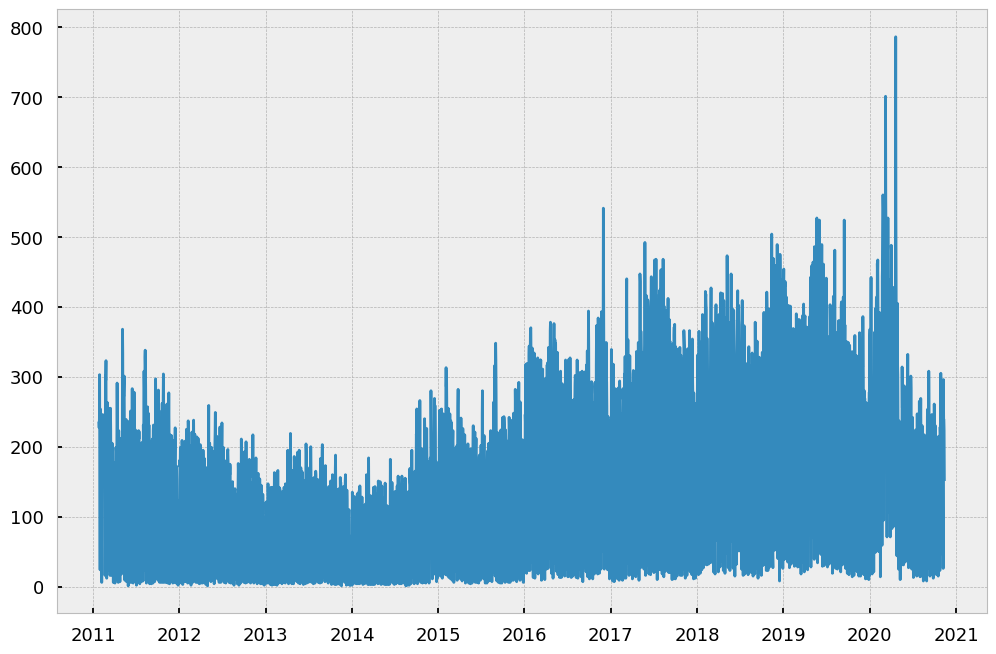

In [24]:
vb["cVb"].groupby(vb.index.date).count().plot()

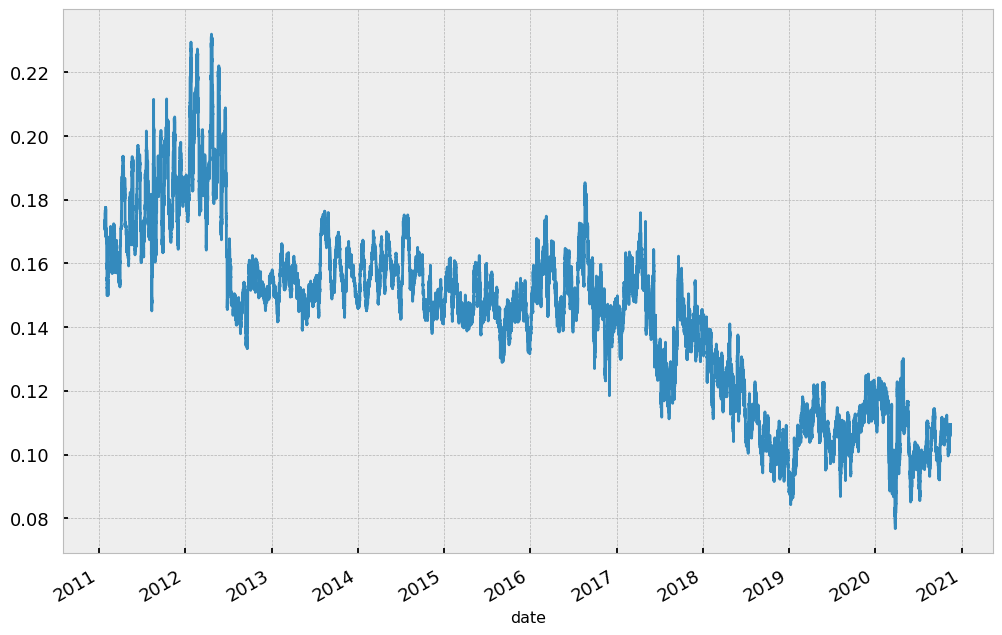

In [25]:
vb.VPIN.plot()

# Microstructural Features

## First Generation: Price Sequences

### Bid-Ask Spread Estimator
Building on the work of Beckers \[1983], Corwin and Schultz \[2012]
introduce a bid-ask spread estimator from high and low prices. The
estimator is based on two principles: 

1. High prices are almost always matched against the offer, and low prices are almost always matched against the bid. The ratio of high-to-low prices reflects fundamental volatility as well as the bid-ask spread. 
2. The component of the high-to-low price ratio that is due to volatility increases proportionately with the time elapsed between two observations.

This procedure is particularly helpful in the corporate bond market, where there is no centralized order book, and trades occur through bids wanted in competition (BWIC). The resulting feature, bid-ask spread S, can be estimated recursively over a rolling window, and values can be smoothed using a Kalman filter.

In [20]:
def getBeta(highLow,sl):
    hl=highLow.values
    hl=np.log(hl[:,0]/hl[:,1])**2
    hl=pd.Series(hl,index=highLow.index)
    beta=hl.rolling(window=2).sum()
    return beta.rolling(window=sl).mean().dropna()

In [21]:
def getGamma(highLow):
    h2=highLow[highLow.columns[0]].rolling(window=2).max()
    l2=highLow[highLow.columns[1]].rolling(window=2).min()
    gamma=np.log(h2.values/l2.values)**2
    return pd.Series(gamma,index=h2.index).dropna()

In [22]:
def getAlpha(beta,gamma):
    den=3-2*2**.5
    alpha=(2**.5-1)*(beta**.5)/den
    alpha-=(gamma/den)**.5
    alpha[alpha<0]=0    #set neg alphas to 0 (see p.722 of paper)
    return alpha.dropna()

In [23]:
def corwinSchultz(highLow,sl=1):
    # Note: S<0 if alpha<0
    beta=getBeta(highLow,sl)
    gamma=getGamma(highLow)
    alpha=getAlpha(beta,gamma)
    spread=2*(np.exp(alpha)-1)/(1+np.exp(alpha))
    startTime=pd.Series(highLow.index[0:spread.shape[0]],index=spread.index)
    spread=pd.concat([spread,startTime],axis=1)
    spread.columns=["spread","startTime"] # 1st loc used to compute beta
    return spread

## Becker-Parkinson Volatility
As a byproduct of this model, we can derive the Becker-Parkinson volatility.

Beckers \[1983] shows that volatility estimators based on high-low prices are more accurate than the standard estimators of volatility based on closing prices.

In [24]:
def getSigma(highLow,sl):
    beta,gamma=getBeta(highLow,sl),getGamma(highLow)
    k2=(8/np.pi)**.5
    den=3-2*2**.5
    sigma=(2**-.5-1)*beta**.5/(k2*den)
    sigma+=(gamma/(k2**2*den))**.5
    sigma[sigma<0]=0
    return sigma

In [25]:
sigma=getSigma(df[["h","l"]],1)

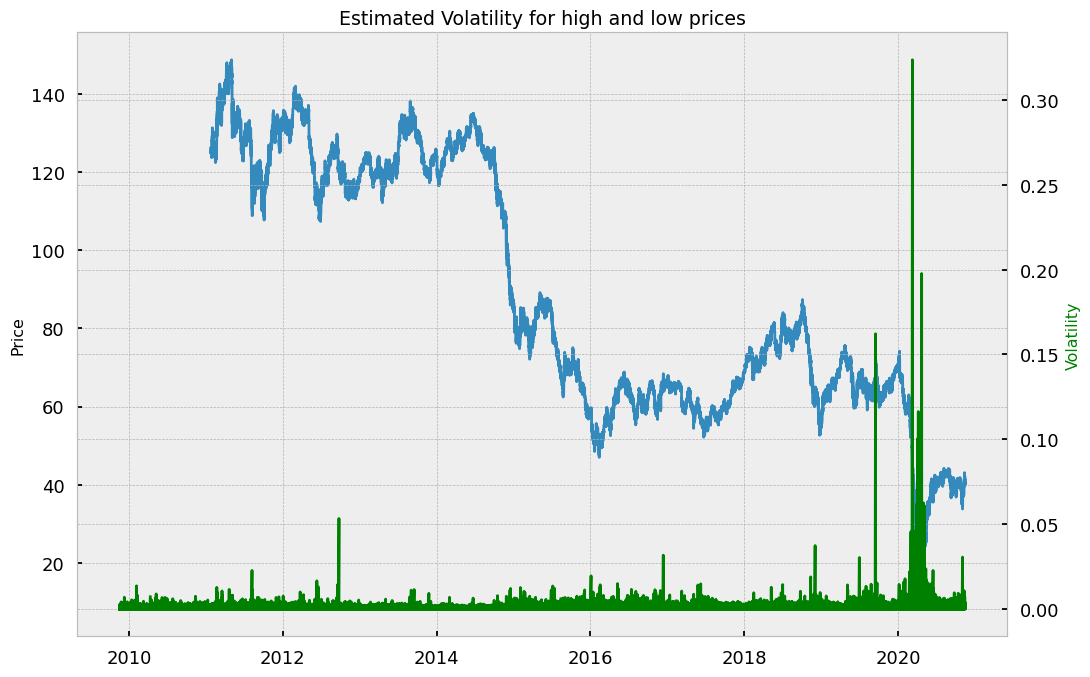

In [26]:
fig,ax=plt.subplots()
ax.set_ylabel("Price")
ax.set_title("Estimated Volatility for high and low prices")
ax.plot(vb.cVb)
ax1 = ax.twinx()
ax1.set_ylabel("Volatility",color="g")
ax1.plot(sigma,color="g")

In [27]:
spread = corwinSchultz(df[["h","l"]],1)

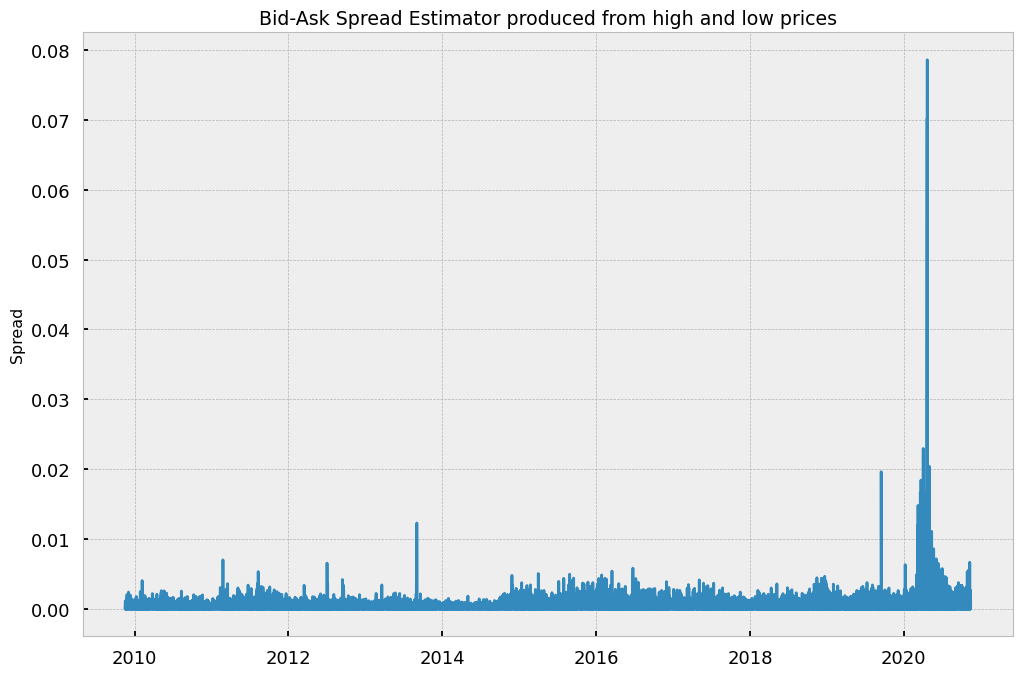

In [28]:
fig,ax=plt.subplots()
ax.set_ylabel("Spread")
ax.set_title("Bid-Ask Spread Estimator produced from high and low prices")
ax.plot(spread["spread"])

**Note**

3Mil x 3Mil scatter plot destroys the jupyter kernel. RAM doesnt matter. To much data, probably plain python file will do the trick.

In [29]:
# idx = spread.index.intersection(sigma.index)
# plt.scatter(sigma.loc[idx],spread.loc[idx,"spread"],s=1)
# plt.title("Spread against Sigma")
# plt.ylabel("spread")
# plt.xlabel("volatility")

## Second Generation: Strategic Trade Models

Second generation microstructural models focus on understanding
and measuring illiquidity. Illiquidity is an important informative
feature in financial ML models, because it is a risk that has an
associated premium. These models have a stronger theoretical
foundation than first-generation models, in that they explain trading
as the strategic interaction between informed and uninformed
traders. In doing so, they pay attention to signed volume and order
flow imbalance.

Most of these features are estimated through regressions. In practice,
I have observed that the t-values associated with these
microstructural estimates are more informative than the (mean)
estimates themselves. 

### Kyle's Lambda

Kyle \[1985] introduced the following strategic trade model. Consider
a risky asset with terminal value $v ∼ N[p_0, \sum_0]$, as well as two traders:
- A noise trader who trades a quantity $u = N[0, σ^2_u]$, independent of $v$.
- An informed trader who knows $v$ and demands a quantity $x$, through a market order.

The market maker observes the total order flow y = x + u, and sets a
price p accordingly. In this model, market makers cannot distinguish
between orders from noise traders and informed traders. They adjust
prices as a function of the order flow imbalance, as that may indicate
the presence of an informed trader. Hence, there is a positive
relationship between price change and order flow imbalance, which
is called market impact.

Here we will derive Kyle's Lambda as microstructural Feature over a rolling window period from bars. Because, i dont have trades and aggressor flags.

In [30]:
def getKylesLambdaFromBars(close:pd.Series,volume:pd.Series,window:int = 20) -> pd.Series:
    """
    Advances in Financial Machine Learning, p. 286-288.
    Get Kyle lambda from bars data
    :param close: (pd.Series) Close prices
    :param volume: (pd.Series) Bar volume
    :param window: (int) Rolling window used for estimation
    :return: (pd.Series) Kyle lambdas
    """
    b = close.diff()
    bv=volume*b.apply(np.sign).replace(0, method='pad')  # bt * Vt
    return (b/bv).rolling(window=window).mean()

In [31]:
kLambda = getKylesLambdaFromBars(df["c"],df["vol"])

In [32]:
k=kLambda*df["c"].diff().apply(np.sign).replace(0, method='pad').loc[kLambda.index]*df.loc[kLambda.index,"vol"]

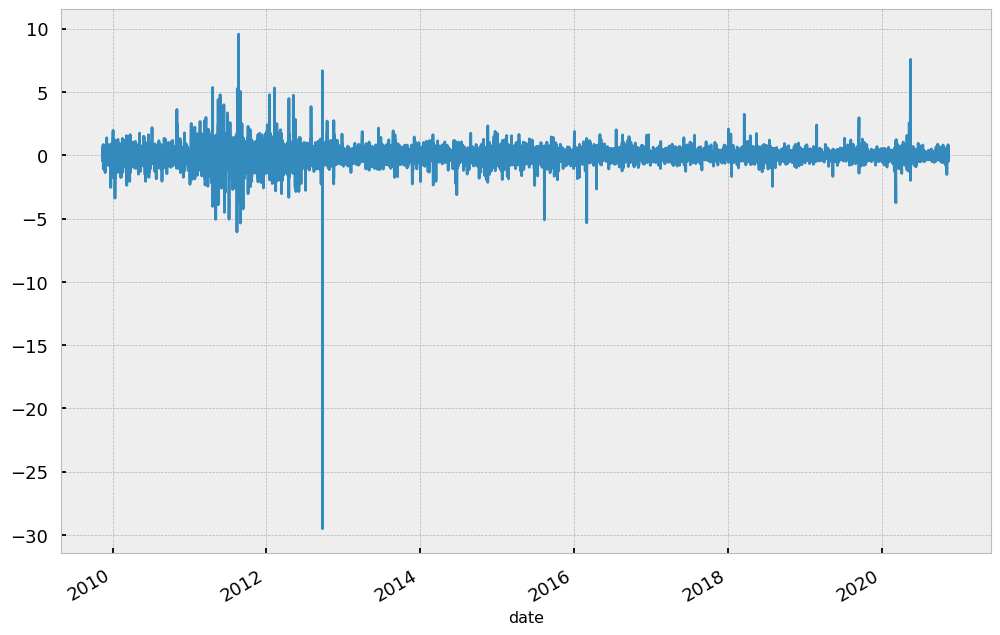

In [33]:
k.plot()

In [34]:
vbK = getKylesLambdaFromBars(vb.cVb, vb.volVb, window=20)

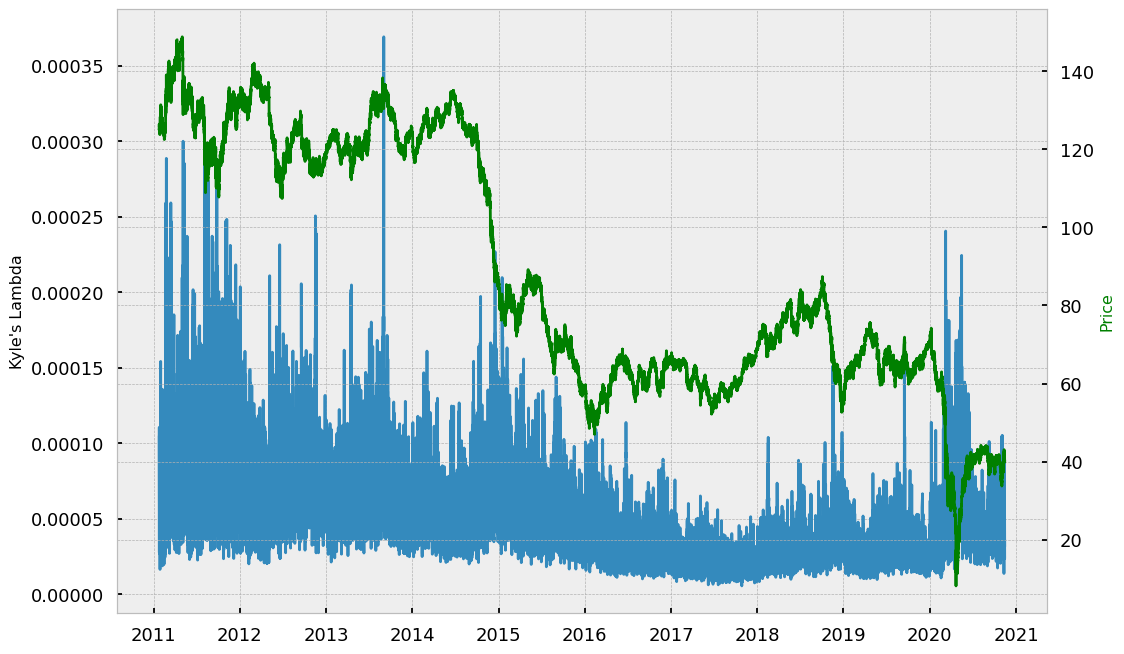

In [35]:
fig, ax = plt.subplots()
ax.set_ylabel("Kyle's Lambda")
ax.plot(vbK)

ax1 = ax.twinx()
ax1.set_ylabel("Price",color="g")
ax1.plot(vb.loc[vbK.index,"cVb"],color="g")

## Third Generation: Sequential Trade Models

### Volume-Synchronized Probability of Informed Trading


In [36]:
def get_vpin(volume: pd.Series, buy_volume: pd.Series, window: int = 1) -> pd.Series:
    """
    Advances in Financial Machine Learning, p. 292-293.
    Get Volume-Synchronized Probability of Informed Trading (VPIN) from bars
    :param volume: (pd.Series) Bar volume
    :param buy_volume: (pd.Series) Bar volume classified as buy (either tick rule, BVC or aggressor side methods applied)
    :param window: (int) Estimation window
    :return: (pd.Series) VPIN series
    """
    sell_volume = volume - buy_volume
    volume_imbalance = abs(buy_volume - sell_volume)
    return volume_imbalance.rolling(window=window).mean() / volume

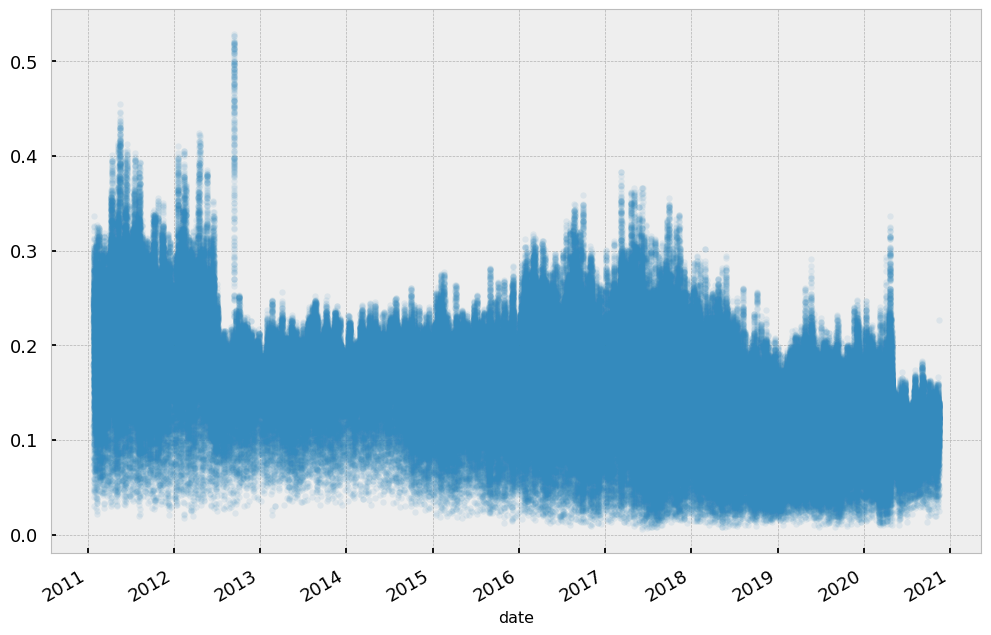

In [54]:
vpin=get_vpin(vb["volVb"],vb["askVolVb"],window=200)
vpin.plot(style=".",alpha=0.1)